# Datacube product metadata and database initialisation
---

## How to run docker-compose to setup docker envionment
Go to `crop-mask/production/dea_ml` folder and run 
```bash
docker-compose up
```
to start the docker dev environment. Then, in other terminal window run 
```bash
docker exec -it dea_ml_stats_1 /bin/bash
```
---

## open datacube dev environment setup

The original doc of [db_setup](https://datacube-core.readthedocs.io/en/latest/ops/db_setup.html).

In project root run ```docker-compose up```. Three containers will be created.

- postgresql, the database for the 
- localstack
- stats

1. ```createdb datacube```
   or
   ```createdb -h <hostname> -U <username> datacube```

2. ```datacube -v system init```

  After the datacube system initialisation, we can have the database with the following structure
  
  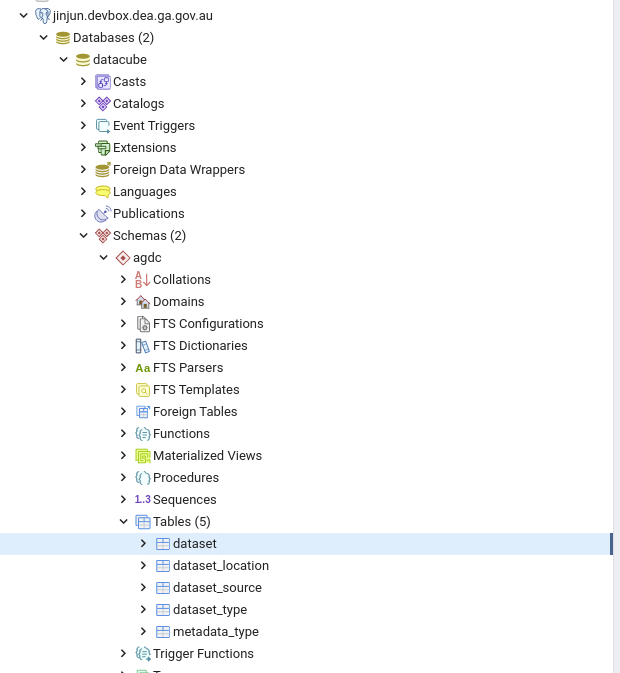
  
  <!--- <img src="../figs/datacube-steps/create_db_sys_init.png"> --->

3. In your local dev envrionment, Python class ```Datacube``` will look for a configuration file in `````~/.datacube.conf`````
which will be edited like sample below

```bash
[datacube]
 db_hostname: localhost
 db_username: postgres
 db_password: opendatacubepassword
```

4. prepare the product meta yaml file and add product into datacube

```bash
datacube product add <product_name>.odc-product.yaml
```
We will have the product meta row in the `dataset_type` table of `agdc` schema inside the `datacube` database.

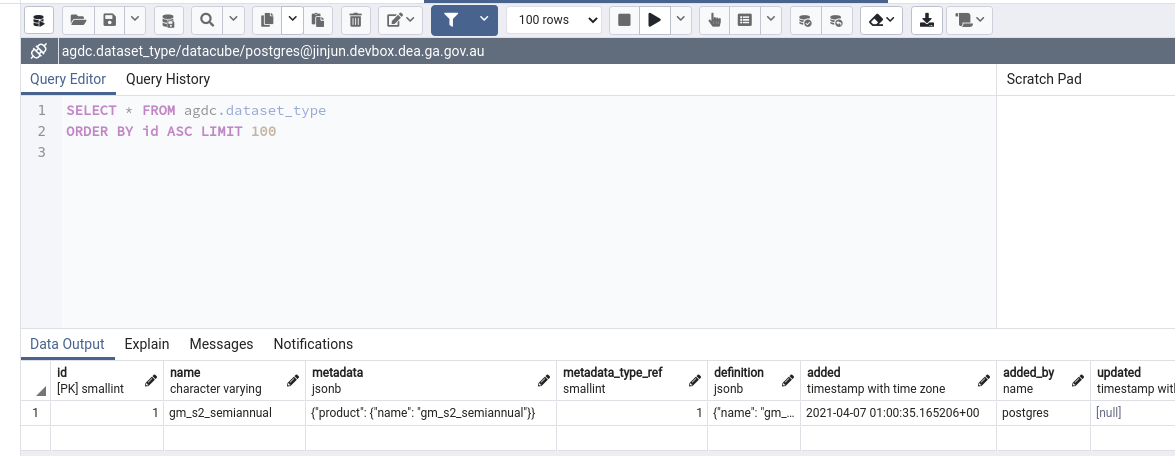

---

#### The product yaml
The product yaml will has following fields. And the `metadata` will be picked up as the signature in the code. All the products definition can be found in the [config](https://github.com/digitalearthafrica/config) repo.

The follow is the `crop_mask` product yaml.

```yaml
---
name: crop_mask_eastern
description: Estern Africa region crop mask prediction based on features
   of s2_l2a statistics gm_tmad, plus NDVI, LAI, MNDWI, rainfall, slope
metadata_type: eo3

license: CC-BY-4.0

metadata:
   product:
      name: crop_mask_eastern

storage:
   crs: epsg:6933
   resolution:
      x: 20
      y: -20
   tile_size:
      x: 96000
      y: 96000

measurements:
   - name: mask
     aliases: ['crop_mask', 'MASK']
     dtype: uint8
     nodata: 255
     units: '1'

   - name: prob
     aliases: ['crop_prob', 'PROB']
     dtype: uint8
     nodata: 255
     units: '1'
```

---

## Add product datasets 
The product datasets were described throught the stac json files after run the following commands in k8s dev pods,
- `odc-stats save-tasks ...` 
- `odc-stats publish-tasks ...`

and, run k8s job of the stats-processing, we will have the datasets ready on s3 target bucket.
- the k8s job will run the tasks configured with a command `odc-stats run ...` and its context.

To add datasets into the database for indexing, we can use `s3-to-dc`
- `s3-to-dc 's3://deafrica-data-dev-af/gm_s2_semiannual/0-1-0/**/*.json' 'gm_s2_semiannual' --stac --no-sign-request --skip-lineage` 

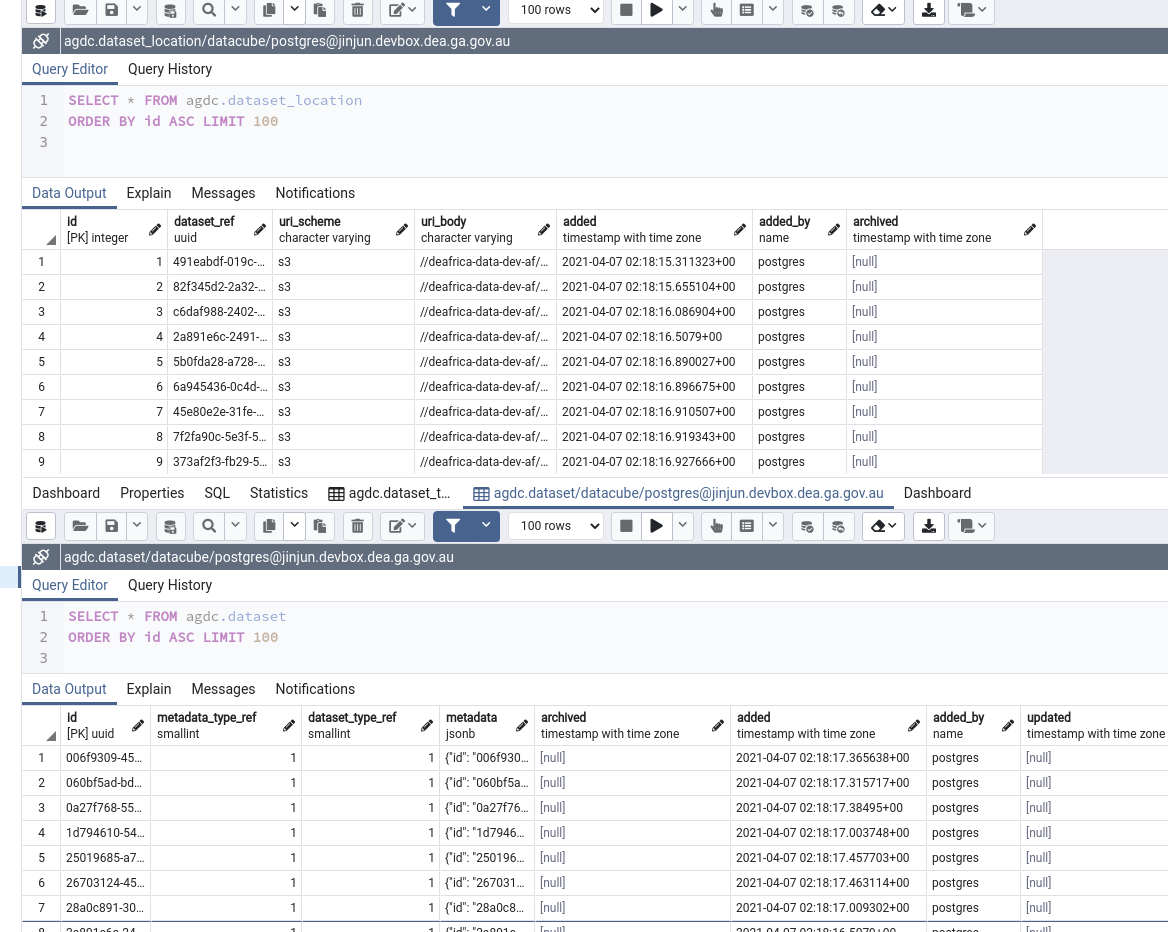

In [3]:
import sys

sys.path.append('../Scripts')

from deafrica_plotting import rgb

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
from datacube import Datacube

dc = Datacube(app='testing')

In [5]:
df_product = dc.list_products()
df_product.head()

,name,description,dataset_maturity,format,lon,label,lat,instrument,product_type,product_family,time,creation_time,region_code,platform,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,,,,
43,alos_palsar_mosaic,ALOS/PALSAR and ALOS-2/PALSAR-2 annual mosaic ...,NaN,GeoTIFF,None,None,None,PALSAR/PALSAR-2,NaN,NaN,None,None,NaN,ALOS/ALOS-2,EPSG:4326,"(-0.000222222222222, 0.000222222222222)","(5, 5)","(latitude, longitude)"
4,crop_mask_eastern,Annual cropland extent map for Eastern Africa ...,NaN,None,None,None,None,None,NaN,NaN,None,None,NaN,None,epsg:6933,"(-20, 20)","(96000, 96000)","(y, x)"
38,gm_s2_annual,Surface Reflectance Annual Geometric Median an...,NaN,None,None,None,None,None,NaN,NaN,None,None,NaN,None,EPSG:6933,"(-10, 10)","(96000.0, 96000.0)","(y, x)"
45,gm_s2_annual_lowres,"Annual Geometric Median, Sentinel-2 - Low Reso...",NaN,None,None,None,None,None,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,NaN
46,gm_s2_semiannual,Surface Reflectance Semiannual Geometric Media...,NaN,None,None,None,None,None,NaN,NaN,None,None,NaN,None,EPSG:6933,"(-10, 10)","(96000.0, 96000.0)","(y, x)"


In [6]:
all_datasets = list(dc.find_datasets(product='gm_s2_semiannual'))

In [7]:
bands = ['blue', 'green', 'red', 'nir', 'swir_1']

ds = dc.load(product='gm_s2_semiannual', geopolygon=all_datasets[0].extent, time=('2019-01', '2021-01'), measurements=bands)

ds

<xarray.Dataset>
Dimensions:      (time: 2, x: 9600, y: 9600)
Coordinates:
  * time         (time) datetime64[ns] 2019-04-01T11:59:59.999999 2019-09-30T...
  * y            (y) float64 -1.92e+06 -1.92e+06 ... -2.016e+06 -2.016e+06
  * x            (x) float64 5.28e+06 5.28e+06 5.28e+06 ... 5.376e+06 5.376e+06
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    green        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    red          (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nir          (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    swir_1       (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

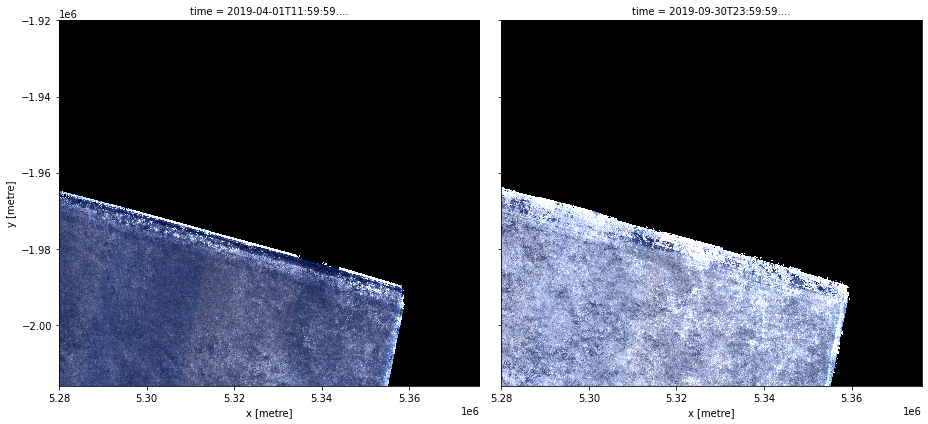

In [9]:
rgb(ds, col='time', col_wrap=2)